In [1]:
import os
import sys
sys.path.append("/home/ubuntu/anaconda3/lib/python3.6/site-packages")
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate as intp
import sys
import time
from matplotlib import animation, rc
from matplotlib.pyplot import figure
import hdf5storage as h5mat
import h5py as h5
import sklearn.model_selection
import pydot
from matplotlib.pyplot import figure
import math

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# Checking the devices available for use in AWS
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11711073032023545725
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11280557671
locality {
  bus_id: 1
  links {
  }
}
incarnation: 733650418911629407
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


In [3]:
# directory info
model_directory = '/home/ubuntu/CS230_project/velocitynn/data/layers/models/'
model_file = '600x200x10000_flat2.mat'
model_path = model_directory+model_file
shot_directory = '/home/ubuntu/CS230_project/velocitynn/data/layers/shots/'
shot_file = '600x200x10000_flat2_1shot.mat'
shot_path=shot_directory+shot_file
filepath=os.getcwd()


In [4]:
# Reading all the shot data
dout = h5.File(shot_path,'r')

# Reading all the velocity models
dout1 = h5.File(model_path,'r')

depth_sample = 10
vel_top = 1500
time_max = 0.8
time_sample = 2e-3
time_interp = np.arange(depth_sample/vel_top, time_max,time_sample)

num_shots = 1000
shot_shape_offset,shot_shape_time  = dout['shot_model_1'].shape
shot_data =  np.zeros((shot_shape_offset,shot_shape_time,num_shots)) #offset, time, samples
vel_rms_data = np.zeros((time_interp.shape[0],num_shots))

for i in range(num_shots):
    shot_data[:,:,i] = dout['shot_model_'+str(i)]
    vp_dummy = dout1['vp'+str(i)]
    vp_dummy = np.transpose(vp_dummy[:,:])
    vp_trace = vp_dummy[:,int(vp_dummy.shape[1]/2)]
    time_diff = depth_sample/vp_trace
    time = np.cumsum(time_diff)
    vp = intp.interp1d(time, vp_trace)(time_interp)
    vel_rms_data[:,i] = np.sqrt(np.cumsum(vp**2)/np.arange(1,vp.shape[0]+1,1))
    
del dout, dout1, vp_dummy, vp_trace, time, vp

print('n_x:',shot_data.shape)
print('n_y:', vel_rms_data.shape)

n_x: (599, 433, 1000)
n_y: (397, 1000)


In [5]:
# Import keras modules for CNN

from keras import layers, initializers, optimizers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
# from kt_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')


Using TensorFlow backend.


In [6]:
# Normalize input and output data
shot_data_normalize = (shot_data - np.min(shot_data, axis =(0,1)))/(np.max(shot_data, axis =(0,1))-np.min(shot_data, axis =(0,1)))
vel_rms_data_normalize = (vel_rms_data - np.min(vel_rms_data, axis=0))/(np.max(vel_rms_data, axis=0) - np.min(vel_rms_data, axis=0))

# Reshape
vel_rms_data_normalize = vel_rms_data_normalize.transpose()
shot_data_normalize = np.swapaxes(shot_data_normalize.transpose(),1,2 )

# Split data into train and test set
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(shot_data_normalize,vel_rms_data_normalize, test_size=0.2, random_state=1)

# X_test, X_val, Y_test, Y_val = sklearn.model_selection.train_test_split(X_test, Y_test, test_size=0.5, random_state=1)

# Add 4th dimension of number of channels=1 to the input data
X_train = np.expand_dims(X_train, axis=3)
# X_val = np.expand_dims(X_val, axis=3)
X_test = np.expand_dims(X_test, axis=3)

print ("number of training examples = " + str(X_train.shape[0]))
# print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
# print ("X_val shape: " + str(X_val.shape))
# print ("Y_val shape: " + str(Y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 800
number of test examples = 200
X_train shape: (800, 599, 433, 1)
Y_train shape: (800, 397)
X_test shape: (200, 599, 433, 1)
Y_test shape: (200, 397)


In [98]:
# Building neural network in Keras 
given_seed = 3 # For repeatibility

def velocitynet(input_shape):
    """
    Implementation of the VelocityNet.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    

    # Define the input placeholder as a tensor with shape input_shape. Input = input shot gather 
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
#     X = ZeroPadding2D((3, 3))(X_input)
    X = X_input

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(16, (7, 7), strides=(2, 2), name='conv0', 
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), strides=(2,2),name='max_pool0')(X)
    
    # Adding Dropout
    X = Dropout(0.3)(X)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (6, 6), strides=(2, 2), name='conv1',
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=3, name='bn1')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), strides=(2,2),name='max_pool1')(X)
    
    # Adding Dropout
    X = Dropout(0.3)(X)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(64, (6, 6), strides=(2, 2), name='conv2',
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=3, name='bn2')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((8, 8), strides=(4,4),name='max_pool2')(X)
    
    # Adding Dropout
    X = Dropout(0.3)(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(397, activation='sigmoid', name='fc')(X)
    X = Activation('relu')(X)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs=X_input, outputs=X, name='velModel')

    return model
    ### END CODE HERE ###

In [99]:
# Create the model
velModel = velocitynet(X_train.shape[1:])


In [100]:
# Summary and plot of the model

velModel.summary()


plot_model(velModel)
SVG(model_to_dot(velModel).create(prog='dot', format='svg'))
plot_model(velModel, to_file='./Figures/model_plot_08Nov_Vishal.png', show_shapes=True, show_layer_names=True)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 599, 433, 1)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 297, 214, 16)      800       
_________________________________________________________________
bn0 (BatchNormalization)     (None, 297, 214, 16)      64        
_________________________________________________________________
activation_21 (Activation)   (None, 297, 214, 16)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 148, 107, 16)      0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 148, 107, 16)      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 72, 51, 32)        18464     
__________

In [101]:
# Learning rate scheduler
from keras.callbacks import LearningRateScheduler
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.1
    epochs_drop = 250.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [102]:
# Compile the model with optimization algorithm, loss function
# from keras.utils import multi_gpu_model
# velModel = multi_gpu_model(velModel, gpus=1)
adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

velModel.compile(loss='mean_squared_error', metrics=['accuracy', 'mse'], optimizer = adam)

In [103]:
# Start the training
# Using learning rate scheduler
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]
history = velModel.fit(X_train, Y_train, validation_split=0.1, epochs=1000, batch_size=32, callbacks=callbacks_list)

# history = velModel.fit(X_train, Y_train, validation_split=0.1, epochs=500, batch_size=32)

Train on 720 samples, validate on 80 samples
Epoch 1/1000
720/720 [==============================] - 5s 7ms/step - loss: 0.0431 - acc: 0.0194 - mean_squared_error: 0.0431 - val_loss: 0.0867 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0867
Epoch 2/1000
720/720 [==============================] - 3s 4ms/step - loss: 0.0164 - acc: 0.0069 - mean_squared_error: 0.0164 - val_loss: 0.0922 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0922
Epoch 3/1000
720/720 [==============================] - 3s 4ms/step - loss: 0.0091 - acc: 0.0250 - mean_squared_error: 0.0091 - val_loss: 0.0947 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0947
Epoch 4/1000
720/720 [==============================] - 3s 4ms/step - loss: 0.0064 - acc: 0.0403 - mean_squared_error: 0.0064 - val_loss: 0.1261 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.1261
Epoch 5/1000
720/720 [==============================] - 3s 4ms/step - loss: 0.0056 - acc: 0.1028 - mean_squared_error: 0.0056 - val_loss: 0.1495 - val_acc:

Epoch 84/1000
720/720 [==============================] - 3s 4ms/step - loss: 0.0016 - acc: 0.6917 - mean_squared_error: 0.0016 - val_loss: 0.0111 - val_acc: 0.3250 - val_mean_squared_error: 0.0111
Epoch 85/1000
720/720 [==============================] - 3s 4ms/step - loss: 0.0017 - acc: 0.6833 - mean_squared_error: 0.0017 - val_loss: 0.0154 - val_acc: 0.0125 - val_mean_squared_error: 0.0154
Epoch 86/1000
720/720 [==============================] - 3s 4ms/step - loss: 0.0018 - acc: 0.6000 - mean_squared_error: 0.0018 - val_loss: 0.0319 - val_acc: 0.0125 - val_mean_squared_error: 0.0319
Epoch 87/1000
720/720 [==============================] - 3s 4ms/step - loss: 0.0017 - acc: 0.6611 - mean_squared_error: 0.0017 - val_loss: 0.0232 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0232
Epoch 88/1000
720/720 [==============================] - 3s 4ms/step - loss: 0.0017 - acc: 0.6222 - mean_squared_error: 0.0017 - val_loss: 0.0223 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0223
Epoch 8

720/720 [==============================] - 3s 4ms/step - loss: 0.0011 - acc: 0.9167 - mean_squared_error: 0.0011 - val_loss: 0.0067 - val_acc: 0.9375 - val_mean_squared_error: 0.0067
Epoch 167/1000
720/720 [==============================] - 3s 4ms/step - loss: 0.0011 - acc: 0.9222 - mean_squared_error: 0.0011 - val_loss: 0.0095 - val_acc: 0.0125 - val_mean_squared_error: 0.0095
Epoch 168/1000
720/720 [==============================] - 3s 4ms/step - loss: 0.0011 - acc: 0.9250 - mean_squared_error: 0.0011 - val_loss: 0.0081 - val_acc: 0.2250 - val_mean_squared_error: 0.0081
Epoch 169/1000
720/720 [==============================] - 3s 4ms/step - loss: 0.0011 - acc: 0.8375 - mean_squared_error: 0.0011 - val_loss: 0.0080 - val_acc: 0.9375 - val_mean_squared_error: 0.0080
Epoch 170/1000
720/720 [==============================] - 3s 4ms/step - loss: 0.0011 - acc: 0.8556 - mean_squared_error: 0.0011 - val_loss: 0.0099 - val_acc: 0.9375 - val_mean_squared_error: 0.0099
Epoch 171/1000
720/720 [=

Epoch 248/1000
720/720 [==============================] - 3s 4ms/step - loss: 9.8482e-04 - acc: 0.9667 - mean_squared_error: 9.8482e-04 - val_loss: 0.0078 - val_acc: 0.9375 - val_mean_squared_error: 0.0078
Epoch 249/1000
720/720 [==============================] - 3s 4ms/step - loss: 9.1906e-04 - acc: 0.9694 - mean_squared_error: 9.1906e-04 - val_loss: 0.0070 - val_acc: 0.9375 - val_mean_squared_error: 0.0070
Epoch 250/1000
720/720 [==============================] - 3s 4ms/step - loss: 8.7505e-04 - acc: 0.9694 - mean_squared_error: 8.7505e-04 - val_loss: 0.0064 - val_acc: 0.9375 - val_mean_squared_error: 0.0064
Epoch 251/1000
720/720 [==============================] - 3s 4ms/step - loss: 8.5716e-04 - acc: 0.9681 - mean_squared_error: 8.5716e-04 - val_loss: 0.0056 - val_acc: 0.9375 - val_mean_squared_error: 0.0056
Epoch 252/1000
720/720 [==============================] - 3s 4ms/step - loss: 7.7975e-04 - acc: 0.9681 - mean_squared_error: 7.7975e-04 - val_loss: 0.0048 - val_acc: 0.9375 - v

Epoch 288/1000
720/720 [==============================] - 3s 4ms/step - loss: 7.9823e-04 - acc: 0.9639 - mean_squared_error: 7.9823e-04 - val_loss: 0.0082 - val_acc: 0.9375 - val_mean_squared_error: 0.0082
Epoch 289/1000
720/720 [==============================] - 3s 4ms/step - loss: 7.5309e-04 - acc: 0.9681 - mean_squared_error: 7.5309e-04 - val_loss: 0.0067 - val_acc: 0.9375 - val_mean_squared_error: 0.0067
Epoch 290/1000
720/720 [==============================] - 3s 4ms/step - loss: 7.5069e-04 - acc: 0.9667 - mean_squared_error: 7.5069e-04 - val_loss: 0.0033 - val_acc: 0.9375 - val_mean_squared_error: 0.0033
Epoch 291/1000
720/720 [==============================] - 3s 4ms/step - loss: 7.5539e-04 - acc: 0.9694 - mean_squared_error: 7.5539e-04 - val_loss: 0.0026 - val_acc: 0.9375 - val_mean_squared_error: 0.0026
Epoch 292/1000
720/720 [==============================] - 3s 4ms/step - loss: 7.6712e-04 - acc: 0.9681 - mean_squared_error: 7.6712e-04 - val_loss: 0.0024 - val_acc: 0.9375 - v

Epoch 328/1000
720/720 [==============================] - 3s 4ms/step - loss: 7.4176e-04 - acc: 0.9694 - mean_squared_error: 7.4176e-04 - val_loss: 0.0030 - val_acc: 0.9375 - val_mean_squared_error: 0.0030
Epoch 329/1000
720/720 [==============================] - 3s 4ms/step - loss: 7.5751e-04 - acc: 0.9722 - mean_squared_error: 7.5751e-04 - val_loss: 0.0042 - val_acc: 0.9375 - val_mean_squared_error: 0.0042
Epoch 330/1000
720/720 [==============================] - 3s 4ms/step - loss: 7.5968e-04 - acc: 0.9722 - mean_squared_error: 7.5968e-04 - val_loss: 0.0026 - val_acc: 0.9375 - val_mean_squared_error: 0.0026
Epoch 331/1000
720/720 [==============================] - 3s 4ms/step - loss: 7.4445e-04 - acc: 0.9708 - mean_squared_error: 7.4445e-04 - val_loss: 0.0028 - val_acc: 0.9375 - val_mean_squared_error: 0.0028
Epoch 332/1000
720/720 [==============================] - 3s 4ms/step - loss: 7.0977e-04 - acc: 0.9736 - mean_squared_error: 7.0977e-04 - val_loss: 0.0034 - val_acc: 0.9375 - v

Epoch 368/1000
720/720 [==============================] - 3s 4ms/step - loss: 7.2407e-04 - acc: 0.9708 - mean_squared_error: 7.2407e-04 - val_loss: 0.0024 - val_acc: 0.9375 - val_mean_squared_error: 0.0024
Epoch 369/1000
720/720 [==============================] - 3s 4ms/step - loss: 7.6068e-04 - acc: 0.9681 - mean_squared_error: 7.6068e-04 - val_loss: 0.0021 - val_acc: 0.9375 - val_mean_squared_error: 0.0021
Epoch 370/1000
720/720 [==============================] - 3s 4ms/step - loss: 7.3946e-04 - acc: 0.9736 - mean_squared_error: 7.3946e-04 - val_loss: 0.0045 - val_acc: 0.9375 - val_mean_squared_error: 0.0045
Epoch 371/1000
720/720 [==============================] - 3s 4ms/step - loss: 7.3229e-04 - acc: 0.9736 - mean_squared_error: 7.3229e-04 - val_loss: 0.0024 - val_acc: 0.9375 - val_mean_squared_error: 0.0024
Epoch 372/1000
720/720 [==============================] - 3s 4ms/step - loss: 7.3444e-04 - acc: 0.9736 - mean_squared_error: 7.3444e-04 - val_loss: 0.0038 - val_acc: 0.9375 - v

Epoch 408/1000
720/720 [==============================] - 3s 4ms/step - loss: 7.1109e-04 - acc: 0.9722 - mean_squared_error: 7.1109e-04 - val_loss: 0.0067 - val_acc: 0.9375 - val_mean_squared_error: 0.0067
Epoch 409/1000
720/720 [==============================] - 3s 4ms/step - loss: 7.1770e-04 - acc: 0.9722 - mean_squared_error: 7.1770e-04 - val_loss: 0.0070 - val_acc: 0.9375 - val_mean_squared_error: 0.0070
Epoch 410/1000
720/720 [==============================] - 3s 4ms/step - loss: 7.3246e-04 - acc: 0.9722 - mean_squared_error: 7.3246e-04 - val_loss: 0.0062 - val_acc: 0.9375 - val_mean_squared_error: 0.0062
Epoch 411/1000
720/720 [==============================] - 3s 4ms/step - loss: 7.2337e-04 - acc: 0.9722 - mean_squared_error: 7.2337e-04 - val_loss: 0.0058 - val_acc: 0.9375 - val_mean_squared_error: 0.0058
Epoch 412/1000
720/720 [==============================] - 3s 4ms/step - loss: 7.2394e-04 - acc: 0.9722 - mean_squared_error: 7.2394e-04 - val_loss: 0.0061 - val_acc: 0.9375 - v

Epoch 448/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.8913e-04 - acc: 0.9736 - mean_squared_error: 6.8913e-04 - val_loss: 0.0030 - val_acc: 0.9375 - val_mean_squared_error: 0.0030
Epoch 449/1000
720/720 [==============================] - 3s 4ms/step - loss: 7.4202e-04 - acc: 0.9722 - mean_squared_error: 7.4202e-04 - val_loss: 0.0026 - val_acc: 0.9375 - val_mean_squared_error: 0.0026
Epoch 450/1000
720/720 [==============================] - 3s 4ms/step - loss: 7.2558e-04 - acc: 0.9736 - mean_squared_error: 7.2558e-04 - val_loss: 0.0022 - val_acc: 0.9375 - val_mean_squared_error: 0.0022
Epoch 451/1000
720/720 [==============================] - 3s 4ms/step - loss: 7.2862e-04 - acc: 0.9736 - mean_squared_error: 7.2862e-04 - val_loss: 0.0030 - val_acc: 0.9375 - val_mean_squared_error: 0.0030
Epoch 452/1000
720/720 [==============================] - 3s 4ms/step - loss: 7.1949e-04 - acc: 0.9736 - mean_squared_error: 7.1949e-04 - val_loss: 0.0037 - val_acc: 0.9375 - v

Epoch 488/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.9781e-04 - acc: 0.9736 - mean_squared_error: 6.9781e-04 - val_loss: 0.0070 - val_acc: 0.9375 - val_mean_squared_error: 0.0070
Epoch 489/1000
720/720 [==============================] - 3s 4ms/step - loss: 7.0648e-04 - acc: 0.9736 - mean_squared_error: 7.0648e-04 - val_loss: 0.0050 - val_acc: 0.9375 - val_mean_squared_error: 0.0050
Epoch 490/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.7301e-04 - acc: 0.9736 - mean_squared_error: 6.7301e-04 - val_loss: 0.0060 - val_acc: 0.9375 - val_mean_squared_error: 0.0060
Epoch 491/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.9257e-04 - acc: 0.9736 - mean_squared_error: 6.9257e-04 - val_loss: 0.0057 - val_acc: 0.9375 - val_mean_squared_error: 0.0057
Epoch 492/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.9141e-04 - acc: 0.9736 - mean_squared_error: 6.9141e-04 - val_loss: 0.0062 - val_acc: 0.9375 - v

Epoch 528/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.7977e-04 - acc: 0.9736 - mean_squared_error: 6.7977e-04 - val_loss: 0.0020 - val_acc: 0.9375 - val_mean_squared_error: 0.0020
Epoch 529/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.7796e-04 - acc: 0.9736 - mean_squared_error: 6.7796e-04 - val_loss: 0.0019 - val_acc: 0.9375 - val_mean_squared_error: 0.0019
Epoch 530/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.6672e-04 - acc: 0.9736 - mean_squared_error: 6.6672e-04 - val_loss: 0.0019 - val_acc: 0.9375 - val_mean_squared_error: 0.0019
Epoch 531/1000
720/720 [==============================] - 3s 4ms/step - loss: 7.0563e-04 - acc: 0.9736 - mean_squared_error: 7.0563e-04 - val_loss: 0.0019 - val_acc: 0.9375 - val_mean_squared_error: 0.0019
Epoch 532/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.4832e-04 - acc: 0.9736 - mean_squared_error: 6.4832e-04 - val_loss: 0.0019 - val_acc: 0.9375 - v

Epoch 568/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.7763e-04 - acc: 0.9722 - mean_squared_error: 6.7763e-04 - val_loss: 0.0018 - val_acc: 0.9375 - val_mean_squared_error: 0.0018
Epoch 569/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.8746e-04 - acc: 0.9736 - mean_squared_error: 6.8746e-04 - val_loss: 0.0018 - val_acc: 0.9375 - val_mean_squared_error: 0.0018
Epoch 570/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.8317e-04 - acc: 0.9736 - mean_squared_error: 6.8317e-04 - val_loss: 0.0020 - val_acc: 0.9375 - val_mean_squared_error: 0.0020
Epoch 571/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.9216e-04 - acc: 0.9736 - mean_squared_error: 6.9216e-04 - val_loss: 0.0021 - val_acc: 0.9375 - val_mean_squared_error: 0.0021
Epoch 572/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.7901e-04 - acc: 0.9736 - mean_squared_error: 6.7901e-04 - val_loss: 0.0018 - val_acc: 0.9375 - v

Epoch 608/1000
720/720 [==============================] - 3s 4ms/step - loss: 7.0378e-04 - acc: 0.9736 - mean_squared_error: 7.0378e-04 - val_loss: 0.0019 - val_acc: 0.9375 - val_mean_squared_error: 0.0019
Epoch 609/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.6502e-04 - acc: 0.9736 - mean_squared_error: 6.6502e-04 - val_loss: 0.0021 - val_acc: 0.9375 - val_mean_squared_error: 0.0021
Epoch 610/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.3952e-04 - acc: 0.9736 - mean_squared_error: 6.3952e-04 - val_loss: 0.0019 - val_acc: 0.9375 - val_mean_squared_error: 0.0019
Epoch 611/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.7365e-04 - acc: 0.9736 - mean_squared_error: 6.7365e-04 - val_loss: 0.0018 - val_acc: 0.9375 - val_mean_squared_error: 0.0018
Epoch 612/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.7267e-04 - acc: 0.9736 - mean_squared_error: 6.7267e-04 - val_loss: 0.0019 - val_acc: 0.9375 - v

Epoch 648/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.4483e-04 - acc: 0.9736 - mean_squared_error: 6.4483e-04 - val_loss: 0.0023 - val_acc: 0.9375 - val_mean_squared_error: 0.0023
Epoch 649/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.6760e-04 - acc: 0.9736 - mean_squared_error: 6.6760e-04 - val_loss: 0.0022 - val_acc: 0.9375 - val_mean_squared_error: 0.0022
Epoch 650/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.7591e-04 - acc: 0.9736 - mean_squared_error: 6.7591e-04 - val_loss: 0.0025 - val_acc: 0.9375 - val_mean_squared_error: 0.0025
Epoch 651/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.7267e-04 - acc: 0.9736 - mean_squared_error: 6.7267e-04 - val_loss: 0.0018 - val_acc: 0.9375 - val_mean_squared_error: 0.0018
Epoch 652/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.8308e-04 - acc: 0.9736 - mean_squared_error: 6.8308e-04 - val_loss: 0.0018 - val_acc: 0.9375 - v

Epoch 688/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.7694e-04 - acc: 0.9736 - mean_squared_error: 6.7694e-04 - val_loss: 0.0024 - val_acc: 0.9375 - val_mean_squared_error: 0.0024
Epoch 689/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.6589e-04 - acc: 0.9736 - mean_squared_error: 6.6589e-04 - val_loss: 0.0020 - val_acc: 0.9375 - val_mean_squared_error: 0.0020
Epoch 690/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.5993e-04 - acc: 0.9736 - mean_squared_error: 6.5993e-04 - val_loss: 0.0020 - val_acc: 0.9375 - val_mean_squared_error: 0.0020
Epoch 691/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.7487e-04 - acc: 0.9736 - mean_squared_error: 6.7487e-04 - val_loss: 0.0021 - val_acc: 0.9375 - val_mean_squared_error: 0.0021
Epoch 692/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.7534e-04 - acc: 0.9736 - mean_squared_error: 6.7534e-04 - val_loss: 0.0020 - val_acc: 0.9375 - v

Epoch 728/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.5864e-04 - acc: 0.9736 - mean_squared_error: 6.5864e-04 - val_loss: 0.0021 - val_acc: 0.9375 - val_mean_squared_error: 0.0021
Epoch 729/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.5778e-04 - acc: 0.9736 - mean_squared_error: 6.5778e-04 - val_loss: 0.0021 - val_acc: 0.9375 - val_mean_squared_error: 0.0021
Epoch 730/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.7720e-04 - acc: 0.9736 - mean_squared_error: 6.7720e-04 - val_loss: 0.0019 - val_acc: 0.9375 - val_mean_squared_error: 0.0019
Epoch 731/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.9112e-04 - acc: 0.9736 - mean_squared_error: 6.9112e-04 - val_loss: 0.0019 - val_acc: 0.9375 - val_mean_squared_error: 0.0019
Epoch 732/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.8754e-04 - acc: 0.9736 - mean_squared_error: 6.8754e-04 - val_loss: 0.0019 - val_acc: 0.9375 - v

Epoch 768/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.3568e-04 - acc: 0.9736 - mean_squared_error: 6.3568e-04 - val_loss: 0.0019 - val_acc: 0.9375 - val_mean_squared_error: 0.0019
Epoch 769/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.7167e-04 - acc: 0.9736 - mean_squared_error: 6.7167e-04 - val_loss: 0.0019 - val_acc: 0.9375 - val_mean_squared_error: 0.0019
Epoch 770/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.5297e-04 - acc: 0.9736 - mean_squared_error: 6.5297e-04 - val_loss: 0.0019 - val_acc: 0.9375 - val_mean_squared_error: 0.0019
Epoch 771/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.4191e-04 - acc: 0.9736 - mean_squared_error: 6.4191e-04 - val_loss: 0.0019 - val_acc: 0.9375 - val_mean_squared_error: 0.0019
Epoch 772/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.8034e-04 - acc: 0.9736 - mean_squared_error: 6.8034e-04 - val_loss: 0.0019 - val_acc: 0.9375 - v

Epoch 808/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.6737e-04 - acc: 0.9736 - mean_squared_error: 6.6737e-04 - val_loss: 0.0019 - val_acc: 0.9375 - val_mean_squared_error: 0.0019
Epoch 809/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.6029e-04 - acc: 0.9736 - mean_squared_error: 6.6029e-04 - val_loss: 0.0019 - val_acc: 0.9375 - val_mean_squared_error: 0.0019
Epoch 810/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.6706e-04 - acc: 0.9736 - mean_squared_error: 6.6706e-04 - val_loss: 0.0019 - val_acc: 0.9375 - val_mean_squared_error: 0.0019
Epoch 811/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.4494e-04 - acc: 0.9736 - mean_squared_error: 6.4494e-04 - val_loss: 0.0019 - val_acc: 0.9375 - val_mean_squared_error: 0.0019
Epoch 812/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.5368e-04 - acc: 0.9736 - mean_squared_error: 6.5368e-04 - val_loss: 0.0019 - val_acc: 0.9375 - v

Epoch 848/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.4567e-04 - acc: 0.9736 - mean_squared_error: 6.4567e-04 - val_loss: 0.0019 - val_acc: 0.9375 - val_mean_squared_error: 0.0019
Epoch 849/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.8600e-04 - acc: 0.9736 - mean_squared_error: 6.8600e-04 - val_loss: 0.0019 - val_acc: 0.9375 - val_mean_squared_error: 0.0019
Epoch 850/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.8168e-04 - acc: 0.9736 - mean_squared_error: 6.8168e-04 - val_loss: 0.0019 - val_acc: 0.9375 - val_mean_squared_error: 0.0019
Epoch 851/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.5485e-04 - acc: 0.9736 - mean_squared_error: 6.5485e-04 - val_loss: 0.0019 - val_acc: 0.9375 - val_mean_squared_error: 0.0019
Epoch 852/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.6721e-04 - acc: 0.9736 - mean_squared_error: 6.6721e-04 - val_loss: 0.0019 - val_acc: 0.9375 - v

Epoch 888/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.8024e-04 - acc: 0.9736 - mean_squared_error: 6.8024e-04 - val_loss: 0.0019 - val_acc: 0.9375 - val_mean_squared_error: 0.0019
Epoch 889/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.6334e-04 - acc: 0.9736 - mean_squared_error: 6.6334e-04 - val_loss: 0.0019 - val_acc: 0.9375 - val_mean_squared_error: 0.0019
Epoch 890/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.6504e-04 - acc: 0.9736 - mean_squared_error: 6.6504e-04 - val_loss: 0.0019 - val_acc: 0.9375 - val_mean_squared_error: 0.0019
Epoch 891/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.3727e-04 - acc: 0.9736 - mean_squared_error: 6.3727e-04 - val_loss: 0.0019 - val_acc: 0.9375 - val_mean_squared_error: 0.0019
Epoch 892/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.6600e-04 - acc: 0.9736 - mean_squared_error: 6.6600e-04 - val_loss: 0.0019 - val_acc: 0.9375 - v

Epoch 928/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.3371e-04 - acc: 0.9736 - mean_squared_error: 6.3371e-04 - val_loss: 0.0019 - val_acc: 0.9375 - val_mean_squared_error: 0.0019
Epoch 929/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.8493e-04 - acc: 0.9736 - mean_squared_error: 6.8493e-04 - val_loss: 0.0019 - val_acc: 0.9375 - val_mean_squared_error: 0.0019
Epoch 930/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.4947e-04 - acc: 0.9736 - mean_squared_error: 6.4947e-04 - val_loss: 0.0020 - val_acc: 0.9375 - val_mean_squared_error: 0.0020
Epoch 931/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.5222e-04 - acc: 0.9736 - mean_squared_error: 6.5222e-04 - val_loss: 0.0019 - val_acc: 0.9375 - val_mean_squared_error: 0.0019
Epoch 932/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.6906e-04 - acc: 0.9736 - mean_squared_error: 6.6906e-04 - val_loss: 0.0019 - val_acc: 0.9375 - v

Epoch 968/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.6834e-04 - acc: 0.9736 - mean_squared_error: 6.6834e-04 - val_loss: 0.0019 - val_acc: 0.9375 - val_mean_squared_error: 0.0019
Epoch 969/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.4577e-04 - acc: 0.9736 - mean_squared_error: 6.4577e-04 - val_loss: 0.0019 - val_acc: 0.9375 - val_mean_squared_error: 0.0019
Epoch 970/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.5473e-04 - acc: 0.9736 - mean_squared_error: 6.5473e-04 - val_loss: 0.0019 - val_acc: 0.9375 - val_mean_squared_error: 0.0019
Epoch 971/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.9288e-04 - acc: 0.9736 - mean_squared_error: 6.9288e-04 - val_loss: 0.0019 - val_acc: 0.9375 - val_mean_squared_error: 0.0019
Epoch 972/1000
720/720 [==============================] - 3s 4ms/step - loss: 6.5535e-04 - acc: 0.9736 - mean_squared_error: 6.5535e-04 - val_loss: 0.0019 - val_acc: 0.9375 - v

In [104]:
# Testing and evaluating the model
preds = velModel.evaluate(X_test, Y_test, batch_size=32, verbose=1, sample_weight=None)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

200/200 [==============================] - 0s 2ms/step

Loss = 0.0017464818712323903
Test Accuracy = 0.97


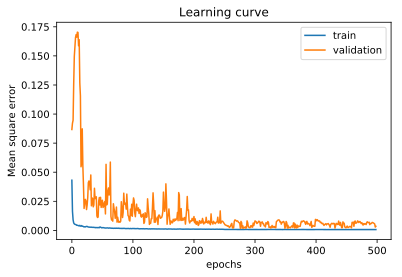

In [132]:
# Plotting the learning curve 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Learning curve')
plt.ylabel('Mean square error')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
# plt.savefig('/Figures/learning_curve_08Nov.png', bbox_inches='tight')

In [112]:
# Save trained model 
# serialize model to JSON
model_json = velModel.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
velModel.save_weights("velModel.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# Load saved model
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
velModel = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("velModel.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

velModel.compile(loss='mean_squared_error', metrics=['accuracy', 'mse'], optimizer = adam)


# To evaluate run the "Testing and evaluating the model" cell

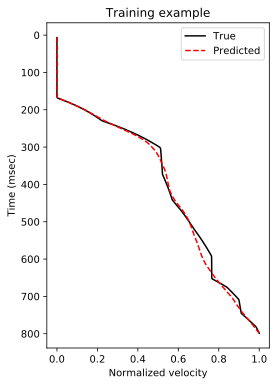

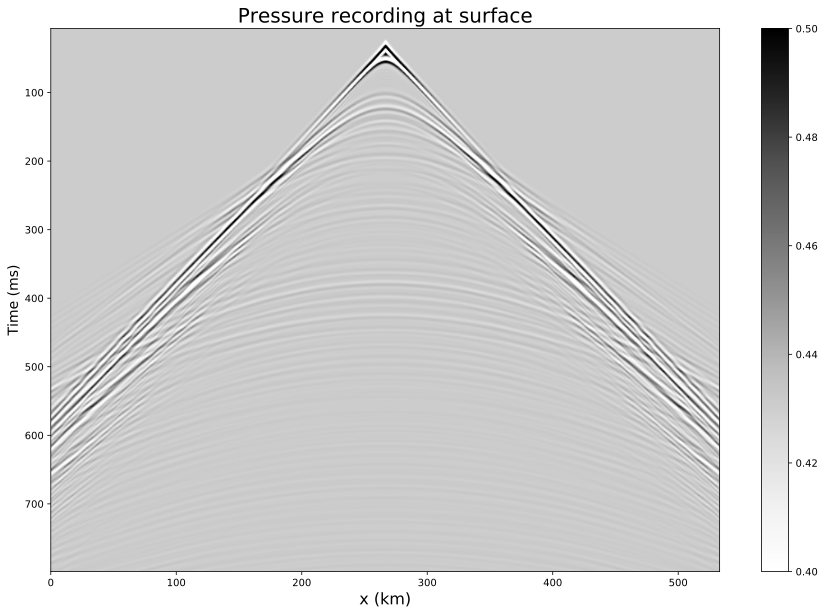

<Figure size 432x288 with 0 Axes>

In [134]:
# Plot some of the training examples - true vs trained
sample_number = 30
X_train_sample = X_train[sample_number,:,:,:]
X_train_sample = np.expand_dims(X_train_sample, axis=0)
Y_train_sample = Y_train[sample_number,:]
Y_train_sample_predict = velModel.predict(X_train_sample)

figure(num=None, figsize=(4, 6), dpi=80, facecolor='w', edgecolor='k')
line1, = plt.plot(Y_train_sample, time_interp*1e3, '-k')
line2, = plt.plot(Y_train_sample_predict[0,:], time_interp*1e3, '--r')
plt.legend((line1, line2), ('True', 'Predicted'))
plt.xlabel('Normalized velocity')
plt.ylabel('Time (msec)')
plt.title('Training example')
plt.gca().invert_yaxis()
plt.savefig('./Figures/training_example_velocity_08Dec.png', bbox_inches='tight')
plt.show()

# clip=0.65;
p_el = np.reshape(X_train[sample_number,:,:,:], (599,433)).transpose()
# vmin=np.min(p_el)*clip;
# vmax=np.max(p_el)*clip;
# fig, ax = plt.subplots(figsize=(10,10))
figure(figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(p_el[:,:], 
               interpolation='bilinear', 
               vmin=0.4, 
               vmax=0.5, 
               cmap=plt.get_cmap('Greys'), 
               aspect='auto',
               origin='upper', extent=[0,533,np.max(time_interp)*1e3,np.min(time_interp)*1e3])
plt.title('Pressure recording at surface', fontsize=20)
plt.xlabel('x (km)', fontsize=16)
plt.ylabel('Time (ms)', fontsize=14)
plt.colorbar()
plt.show()
plt.savefig('./Figures/training_example_seismic_08Dec.png', bbox_inches='tight')

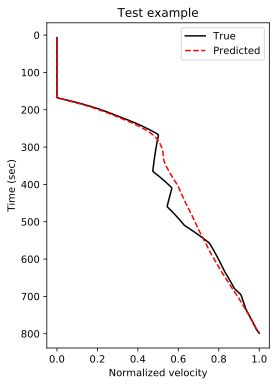

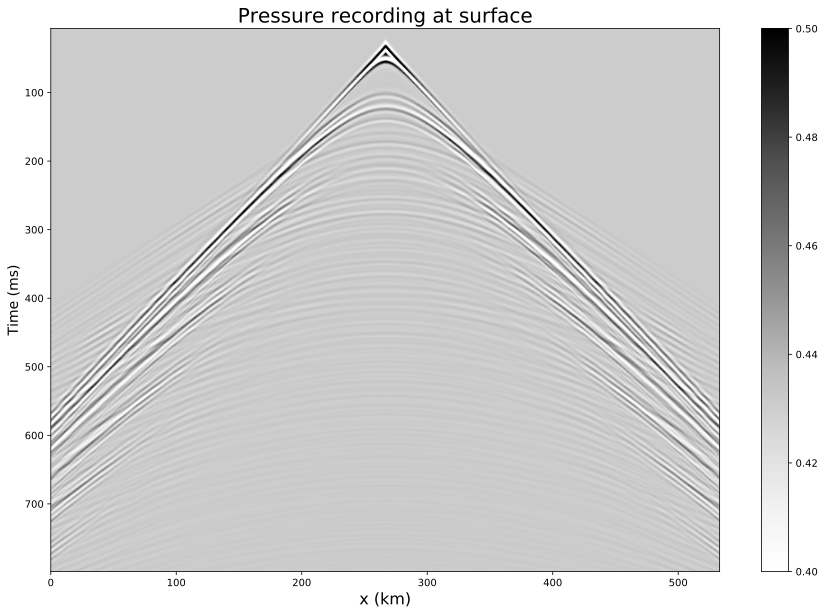

<Figure size 432x288 with 0 Axes>

In [138]:
# Plot some of test examples
sample_number = 10 # 4, 40, 15, 25, 33
X_test_sample = X_test[sample_number,:,:,:]
X_test_sample = np.expand_dims(X_test_sample, axis=0)
Y_test_sample = Y_test[sample_number,:]
Y_test_sample_predict = velModel.predict(X_test_sample)

figure(num=None, figsize=(4, 6), dpi=80, facecolor='w', edgecolor='k')
line1, =plt.plot(Y_test_sample, time_interp*1e3, '-k')
line2, = plt.plot(Y_test_sample_predict[0,:], time_interp*1e3, '--r')
plt.legend((line1, line2), ('True', 'Predicted'))
plt.title('Test example')
plt.xlabel('Normalized velocity')
plt.ylabel('Time (sec)')
plt.gca().invert_yaxis()
plt.savefig('Figures/test_example_velocity_08Dec_1.png', bbox_inches='tight')
plt.show()

# clip=0.65;
p_el = np.reshape(X_test[sample_number,:,:,:], (599,433)).transpose()
# vmin=np.min(p_el)*clip;
# vmax=np.max(p_el)*clip;
# fig, ax = plt.subplots(figsize=(10,10))
figure(figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(p_el[:,:], 
               interpolation='bilinear', 
               vmin=0.4, 
               vmax=0.5, 
               cmap=plt.get_cmap('Greys'), 
               aspect='auto',
               origin='upper', extent=[0,533,np.max(time_interp)*1e3,np.min(time_interp)*1e3])
plt.title('Pressure recording at surface', fontsize=20)
plt.xlabel('x (km)', fontsize=16)
plt.ylabel('Time (ms)', fontsize=14)
plt.colorbar()
plt.show()
plt.savefig('Figures/test_example_seismic_08Dec_1.png', bbox_inches='tight')